# Clasificación Multiclases y Redes Neuronales


In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-muted')
plt.style.use('ggplot')
import scipy.optimize as opt
#from scipy.optimize import minimize

# Funciones

In [2]:
def print_array(array, end = "\n"):
    #np.set_printoptions(precision=3)
    """Funcion para escribir una lista espaceada o salto de linea"""
    for a in array:
        print(" {0:5.6f}".format(a), end = end)

def display_data(X):
    """
    Transforms each input row into a rectangular image part and plots
    the resulting image.
    """
    m, n = X.shape 
    
    example_width = int(np.around(np.sqrt(n))) # anchura de pixels
    example_height = int(n / example_width) # altura pixels
       
    # calcular filas y columnas de la matriz a mostrar
    display_rows = int(np.sqrt(m))
    display_cols = int(m / display_rows)   
    
    # padding entre las imagenes
    pad = 1
    
    display_array = -np.ones((pad + display_rows * (example_height + pad),  
                              pad + display_cols * (example_width + pad)))
    
   # Copy example into a patch on the display array
    curr_ex = 0
    
    for i in range(display_rows):
        for j in range(display_cols):
            
            if curr_ex < m:                
                
                # obtener maximo valor para normalizar ejemplos
                max_val = max(abs(X[curr_ex, :]))
            
                rows = pad + (i) * (example_height + pad) + np.array(range(example_height))
                cols = pad + (j) * (example_width + pad) + np.array(range(example_width ))
            
                img = np.reshape(X[curr_ex, :], (example_height, example_width))
                
                display_array[ rows[0]: rows[-1] + 1 , cols[0]: cols[-1] + 1 ] = img / max_val
                
                curr_ex += 1
           
            else:
                break          
             
    plt.figure(figsize=(8,8))
    plt.imshow(display_array.T, plt.cm.gray)
    plt.axis("off")
   
    plt.show()
    
def sigmoid(z):
    """SIGMOID Compute sigmoid function
       g = SIGMOID(z) computes the sigmoid of z."""
    #inicializar variables
    g = np.zeros(z.shape)    
    g = 1. / (1 + np.exp(-z))
    
    return g

def lrCostFunction(theta, X, y, lamda):
    """
    COSTFUNCTIONREG Compute cost and gradient for logistic regression with regularization
    J = COSTFUNCTIONREG(theta, X, y, lambda) computes the cost of using
    theta as the parameter for regularized logistic regression and the
    gradient of the cost w.r.t. to the parameters. 
    """
    # inicializar valores utiles
    m  = len(y)
    # inicializar valores a retornar
    J = 0.
    grad = np.zeros(theta.shape)
    
    z = np.dot(X,theta)
    h = sigmoid(z)
    # calcular error
    e = h - y
    
    # J =  (1/m)  * (a - b) + (lambda/2m)* c    
    k =  1./m 
    a = -y@np.log(h)
    b = (1 - y)@np.log(1 - h)
    reg = (0.5 *lamda)/m
    c = theta[1:]@theta[1:]
    
    J =  ( k * ( a - b ) )  + ( reg * c )    
    
    grad[0] = k * ( X[:,0].T @ e )    
    grad[1:] = k * ( X[:,1:].T @ e ) + ( 2*reg )*theta[1:]   
                  
    return (J, grad)

def J(theta, X, y, lamda):  
    """return J value"""
    return lrCostFunction(theta, X, y, lamda)[0].reshape((1,))

def gradient(theta, X, y, lamda): 
    """return gradient"""
    return lrCostFunction(theta, X, y, lamda)[1] 

def oneVsAll(X, y, num_labels, lamda):
        
    # algunas variables utiles
    m = X.shape[0] # número de ejemplos
    n = X.shape[1] # número de variables
    
    # variable a retornar
    all_theta = np.zeros( (num_labels, n+1) )
    all_cost = np.zeros( (n+1,) )
    # adicionar unos a la matriz de datos
    X = np.hstack( (np.ones((m, 1)), X) )   
    
    for c in range(1, num_labels + 1):
        print("Training {:d} out of {:d} categories ->".format(c, num_labels), end="")
        label = (y == c)*1   
        initial_theta = np.zeros((n+1))        
    
        #sol = opt.fmin_cg(J, x0=initial_theta, fprime=gradient, args=(X, label, lamda), disp=0)
        #val = opt.fmin_bfgs(J, initial_theta, fprime=gradient, args=(X, label, lamda), full_output = True, disp = False)
        #val = opt.minimize(J, initial_theta, args=(X, label, lamda), method= 'BFGS', jac=gradient)

        args=(X, label, lamda)
        val = opt.fmin_cg(J, initial_theta, fprime=gradient, args=args, full_output = True, disp = False)
        cost, theta = val[1], val[0]
     
        print(" costo = {0:e}".format(cost))
        #print("Theta =\n", theta[0:20])
        all_theta[c-1:] = theta
        all_cost[c-1] = cost
    return (all_theta, all_cost)

def predictOneVsAll(all_theta, X):
    """
    PREDICT Predict the label for a trained one-vs-all classifier. The labels 
    are in the range 1..K, where K = size(all_theta, 1). 
    p = PREDICTONEVSALL(all_theta, X) will return a vector of predictions
    for each example in the matrix X. Note that X contains the examples in
    rows. all_theta is a matrix where the i-th row is a trained logistic
    regression theta vector for the i-th class. You should set p to a vector
    of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
    for 4 examples) 
    """
    m = X.shape[0]
    p = np.zeros( (m,) )
    
    # adicionar columnas de unos a la matriz X
    X = np.hstack( (np.ones((m, 1)), X) )
    h = sigmoid( X @ all_theta .T ) 
    p = np.argmax( h, axis = 1 ) + 1
    
    return p

## Parte 1: Cargar y Visualizar Datos

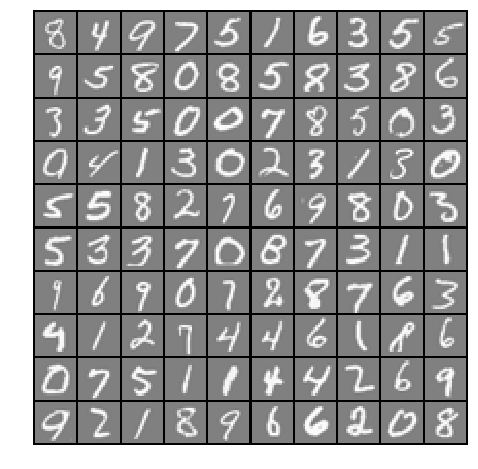

In [7]:
input_layer_size = 400 # 20 x 20 imagenes de entrada
num_labels = 10        # 10 etiquetas de 1 a 10

# cargar datos
mat = scipy.io.loadmat('ex3data1.mat') #lectura de file .mat, cargados en un diccionario con X, y como llaves
X = mat["X"]
y = mat["y"]
y = y.reshape((len(y),))
m = X.shape[0]

# seleccionar aleatoriamente 100 data point para mostrar
rand_indices = np.random.permutation(m)

sel = X[rand_indices[0:100],:]

display_data(sel)


## Parte 2a: Vectorice la regreción logistica

In [4]:
# testear caso para lrCostFunction
print("Testeando lrCostFunction() con regularización\n")

tetha_t = np.array([-2., -1., 1., 2.])
X_t = np.hstack(( np.ones((5,1)), (np.reshape(range(1,16), (5,3), order="F"))/10 ))
y_t = np.array([1, 0, 1, 0, 1])
lamda_t = 3

cost, grad = lrCostFunction(tetha_t, X_t, y_t, lamda_t)

print("Costo: {0:5.6f}".format(cost))
print("Costo esperado: 2.534819\n")
print("Gradientes:")
print_array(grad)
print("Gradientes Esperados:")
print(" 0.146561\n -0.548558\n 0.724722\n 1.398003")

Testeando lrCostFunction() con regularización

Costo: 2.534819
Costo esperado: 2.534819

Gradientes:
 0.146561
 -0.548558
 0.724722
 1.398003
Gradientes Esperados:
 0.146561
 -0.548558
 0.724722
 1.398003


## Parte 2b: Entrenamiento One-vs-All

In [5]:
lamda = 0.1
all_theta, all_cost = oneVsAll(X, y, num_labels, lamda)

Training 1 out of 10 categories -> costo = 1.311942e-02
Training 2 out of 10 categories -> costo = 5.081263e-02
Training 3 out of 10 categories -> costo = 5.761122e-02
Training 4 out of 10 categories -> costo = 3.308823e-02
Training 5 out of 10 categories -> costo = 5.445806e-02
Training 6 out of 10 categories -> costo = 1.825865e-02
Training 7 out of 10 categories -> costo = 3.066683e-02
Training 8 out of 10 categories -> costo = 7.846117e-02
Training 9 out of 10 categories -> costo = 7.119841e-02
Training 10 out of 10 categories -> costo = 8.569235e-03


## Parte 3: Predicciones para One-Vs-All

In [6]:
pred = predictOneVsAll(all_theta, X) 
print("Presición del enetrenamiento: {0:5.2f}%\n".format( np.mean((pred == y)) * 100))

Presición del enetrenamiento: 96.46%

